# Overfitting and earthquake frequencies

This notebook explores a simulation of earthquake frequencies based on the discussion in Chapter 5 "Desperately Seeking Signal" of The Signal and the Noise by Nate Silver.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Gutenberg-Richter law

The Gutenberg-Richter law relates the magnitude and total number of earthquakes in any given region and time period of at least that magnitude.

$$ N = 10^{a-bM} = 10^a 10^{-bM} $$

- $N$ is the number of events with magnitude $ \geq M$.
- $a$ and $b$ are constants that depend on the region
- $b$ is a constant close to 1 in seismically active regions
- $a$ is just part of the proportionality constant for that region

$$ N \propto 10^{-b M} $$

Another way of expression this is a transformed model

$$ \log_{10} N = a - bM $$

So if we make a semilog plot of $\log_{10} N$ vs. $M$ it should be a straight line.

There is more to it than this, but let's use this model to study a simple simulation.

## Simulating a geographic region

Consider the frequency of earthquakes over a hundred year period as a function of $M$.

Let's create a hypothetical geographic region with an underlying value of $b=1$ and $a=10$. That means there are about $10^{10}$ very low-magnitude earthquakes per year in this region. 

In [19]:
a_true = 10
b_true = 1.0

Now let's create a simulation of the region to imagine what observations might look like of different magnitude earthquakes from 0 to 9. Let's make our simulation so that magnitude observations are noisy at large magnitudes, reflecting that not many of these happen per year and so are harder to measure.

In [24]:
n_m_vals = 20
magnitude_vals = np.linspace(0.001,9.0,num=n_m_vals)
observed_freq = np.empty(n_m_vals)
gr_law_true = np.empty(n_m_vals)

In [25]:
np.random.seed(1)
for i in range(0, n_m_vals):
    # this adds noise that changes with magnitude
    observed_freq[i] = (10.**a_true * 10.**(-b_true * magnitude_vals[i]))\
                + 10**(a_true - 0.9*magnitude_vals[i])*np.random.normal()
    gr_law_true[i] = 10.**a_true * 10.**(-b_true * magnitude_vals[i])
    if observed_freq[i] < 0:
        observed_freq[i] = abs(observed_freq[i])

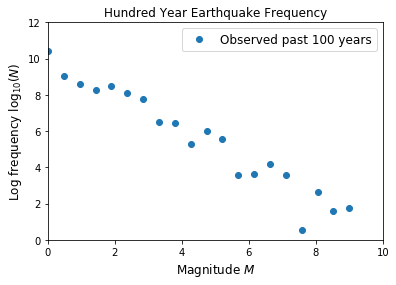

In [33]:
plt.plot(magnitude_vals, np.log10(observed_freq),'o', label='Observed past 100 years')
#plt.plot(magnitude_vals, np.log10(gr_law_true), '-', label='Underlying Gutenberg-Richter Law')
plt.xlim(0,10)
plt.ylim(0,12)
plt.title('Hundred Year Earthquake Frequency')
plt.xlabel(r'Magnitude $M$', fontsize=12)
plt.ylabel(r'Log frequency $\log_{10}(N)$', fontsize=12)
plt.legend(fontsize=12);

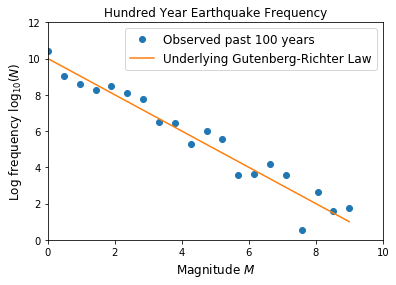

In [26]:
plt.plot(magnitude_vals, np.log10(observed_freq),'o', label='Observed past 100 years')
plt.plot(magnitude_vals, np.log10(gr_law_true), '-', label='Underlying Gutenberg-Richter Law')
plt.xlim(0,10)
plt.ylim(0,12)
plt.title('Hundred Year Earthquake Frequency')
plt.xlabel(r'Magnitude $M$', fontsize=12)
plt.ylabel(r'Log frequency $\log_{10}(N)$', fontsize=12)
plt.legend(fontsize=12);

Now what happens if we treat this different ways using naive methods, and try to predict the hundred year frequency of an earthquake of magnitudes 9.1, 9.3, and 9.5 and see how different the results are.

## Method 1: Naive least-squares fit

Let's use the linear least-squares function from previous labs to fit the transformed semi-log data.

In [27]:
from linear_fitting_functions import least_squares_optimizer_fit_linear

In [28]:
npred = 100
magnitude_pred = np.linspace(0,10,num=npred)

After 2 iterations...
The optimization was successful! Here are the values it found:
       m =    -0.9790
       b =     9.9974
             x value     residual squared
              0.0010               0.1778
              0.4746               0.2555
              0.9483               0.2324
              1.4219               0.1144
              1.8955               0.1101
              2.3692               0.1813
              2.8428               0.3390
              3.3164               0.0703
              3.7901               0.0287
              4.2637               0.3165
              4.7373               0.3991
              5.2109               0.4351
              5.6846               0.6882
              6.1582               0.1288
              6.6318               0.4321
              7.1055               0.2713
              7.5791               4.2353
              8.0527               0.2471
              8.5264               0.0038
              9.0000           

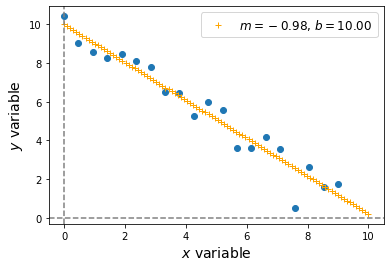

In [29]:
least_squares_optimizer_fit_linear(magnitude_vals, np.log10(observed_freq), -1,10,magnitude_pred)

So the extract value here is $a=10$ and $b=0.98$ which makes the model

$$ \log_{10} N = 10 - 0.98 M $$

In [43]:
a_ls = 10
b_ls = 0.98

## Method 2: Chebyshev's method

Let's try to use Chebyshev's method for the fit and see what happens

In [31]:
from linear_fitting_functions import chebyshev_linprog_fit_linear

Performing linear program optimization with bounds:
       r =          0      14.85
       m =      -1.33      -0.67
       b =       6.70      13.30
After 49 iterations...
The optimization was successful! Here are the values it found:
       r =     1.4539
       m =    -0.9225
       b =     8.9651
Check: Largest absolute error is r = 1.45 
 It occurs when x =  7.5791


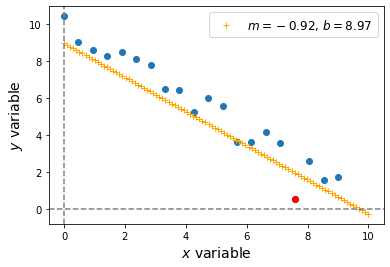

In [32]:
chebyshev_linprog_fit_linear(magnitude_vals, np.log10(observed_freq),magnitude_pred, -1,10)

In [42]:
a_cm = 8.965
b_cm = 0.9225

So this method gives a model of $a=8.965$ and $b=0.9225$. Note that it prioritizes the noisy observation below magnitude 8 because it doesn't like any one point to be too far away.

## Method 3: Polynomial model

Although we know it's unlikely to be very good, let's also try a high-order polynomial interpolating model and see what happens.

In [34]:
Amx = np.empty((n_m_vals,n_m_vals))
for i in range(0, n_m_vals):
    for j in range(0, n_m_vals):
        Amx[i,j] = magnitude_vals[i]**float(j)

In [38]:
avec = np.linalg.solve(Amx, np.log10(observed_freq))

In [39]:
npred_poly = 1000
magnitude_pred_poly = np.linspace(0,10,num=npred_poly)
freq_pred3 = np.empty(npred_poly)
for i in range(0,npred_poly):
    freq_pred3[i] = 0.0
    for j in range(0, n_m_vals):
        freq_pred3[i] += avec[j] * magnitude_pred_poly[i]**float(j)

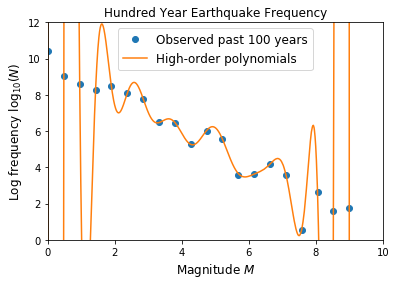

In [44]:
plt.plot(magnitude_vals, np.log10(observed_freq),'o', label='Observed past 100 years')
plt.plot(magnitude_pred_poly, freq_pred3, '-', label='High-order polynomials')
plt.xlim(0,10)
plt.ylim(0,12)
plt.title('Hundred Year Earthquake Frequency')
plt.xlabel(r'Magnitude $M$', fontsize=12)
plt.ylabel(r'Log frequency $\log_{10}(N)$', fontsize=12)
plt.legend(fontsize=12);

Yikes! That's totally not right.

## Plot them all together

Let's plot all three models together along with the underlying model

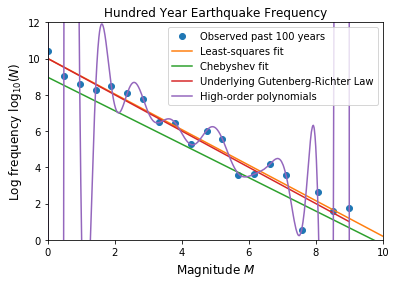

In [46]:
plt.plot(magnitude_vals, np.log10(observed_freq),'o', label='Observed past 100 years')
plt.plot(magnitude_pred_poly, a_ls - b_ls*magnitude_pred_poly, '-', label='Least-squares fit')
plt.plot(magnitude_pred_poly, a_cm - b_cm*magnitude_pred_poly, '-', label='Chebyshev fit')
plt.plot(magnitude_vals, np.log10(gr_law_true), '-', label='Underlying Gutenberg-Richter Law')
plt.plot(magnitude_pred_poly, freq_pred3, '-', label='High-order polynomials')
plt.xlim(0,10)
plt.ylim(0,12)
plt.title('Hundred Year Earthquake Frequency')
plt.xlabel(r'Magnitude $M$', fontsize=12)
plt.ylabel(r'Log frequency $\log_{10}(N)$', fontsize=12)
plt.legend(fontsize=10);